# **Script and outputs for training a CNN for model selection, perform cross-validation and predict the most likely model from empirical data in the species *Euphorbia segueriana*.**
From the manuscript Kirschner & Perez et al. (2022) "Congruent evolutionary responses of European steppe biota to late Quaternary climate change: insights from convolutional neural network-based demographic modeling".

All required files are available at the GitHub directory, except for the simulations, that can be downloaded here: https://drive.google.com/file/d/1GdTSSu_RwWAljqA8dpj-FW1juiojhJqb/view?usp=sharing. Please copy them to your Google Drive landing page.

In [1]:
# Connect the notebook with your Google Drive.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Section 1: Building the CNN.**

In [ ]:
# Import all required modules.

import sys, os
import numpy as np
import time
import random
from random import shuffle, choice
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
from keras.utils import np_utils
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import sklearn.metrics as metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define parameters for the CNN run.
batch_size = 200
### how much interations to train the network
epochs = 100

###n of models
num_classes = 3


# Define the CNN architecture.
def create_cnn(xtest):
	inputShape = (xtest.shape[1], xtest.shape[2])
	## image size. images need to have EXACTLY the same size
	inputs = Input(shape=inputShape)
	x = inputs
	## 1D convolution - less computational intensive and also treats snps as independent;
	x = Conv1D(250, kernel_size=2, activation='relu',input_shape=(xtest.shape[1], xtest.shape[2]))(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	x = Conv1D(125, kernel_size=2, activation='relu')(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	x = Conv1D(125, kernel_size=2, activation='relu')(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	### Linearising the image as in the initial step. From this point on the network behaves as a Multi-Layer Perceptron.
	x = Flatten()(x)
	x = Dense(125, activation='relu',kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(x)
	x = Dropout(0.5)(x)
	x = Dense(125, activation='relu',kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(x)
	x = Dropout(0.5)(x)
	x = Dense(num_classes, activation="softmax")(x)

	# Construct the CNN.
	model = Model(inputs, x)
	# Return the CNN.
	return model

ImportError: cannot import name 'np_utils' from 'keras.utils' (/usr/local/lib/python3.10/dist-packages/keras/utils/__init__.py)

## **Section 2: Train the network with 1,000 simulations from each model**

First, unzip the folder containing the simulations and load them as NumPy arrays. Associate each simulation with the appropriate label and shuffle their order.

In [ ]:
!unzip "/content/drive/MyDrive/simulations.zip"

u1 = np.load("/content/simulations/trainingSims/simModel1.npy",mmap_mode='r')
u2 = np.load("/content/simulations/trainingSims/simModel2.npy",mmap_mode='r')
u3 = np.load("/content/simulations/trainingSims/simModel3.npy",mmap_mode='r')

# Combine all arrays.
x=np.concatenate((u1,u2,u3),axis=0)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(x):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      x[arr][idx][x[arr][idx] == 1] = -1
      x[arr][idx][x[arr][idx] == 0] = 1
    else:
      x[arr][idx][x[arr][idx] == 0] = -1

# Label each simulated array.
y=[0 for i in range(len(u1))]
y.extend([1 for i in range(len(u2))])
y.extend([2 for i in range(len(u3))])
y = np.array(y)

#delete temporary files to free memory.
del (u1,u2,u3)

# Shuffle the arrays for training, keeping the labels in the same order.
shf = list(range(len(x)))
shuffle(shf)
y = y[shf]
x = x[shf]


Archive:  /content/drive/MyDrive/Day4/simulations.zip
   creating: simulations/
  inflating: __MACOSX/._simulations  
   creating: simulations/testSims/
  inflating: __MACOSX/simulations/._testSims  
  inflating: simulations/.DS_Store   
  inflating: __MACOSX/simulations/._.DS_Store  
   creating: simulations/trainingSims/
  inflating: __MACOSX/simulations/._trainingSims  
  inflating: simulations/testSims/.DS_Store  
  inflating: __MACOSX/simulations/testSims/._.DS_Store  
  inflating: simulations/testSims/parameters.txt  
  inflating: __MACOSX/simulations/testSims/._parameters.txt  
  inflating: simulations/testSims/simModel2.npy  
  inflating: simulations/testSims/simModel3.npy  
  inflating: __MACOSX/simulations/testSims/._simModel3.npy  
  inflating: simulations/testSims/simModel1.npy  
  inflating: simulations/trainingSims/.DS_Store  
  inflating: __MACOSX/simulations/trainingSims/._.DS_Store  
  inflating: simulations/trainingSims/parameters.txt  
  inflating: __MACOSX/simulatio

In [ ]:
# Print label and simulations length, these should be the same.
print (len(x), len(y))

# Check array sizes as well just to be sure.
print (x.shape)

print (y.shape)

3000 3000
(3000, 1000, 270)
(3000,)


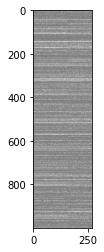

In [ ]:
#Export an image from the training data, to visualize its appearance
import matplotlib.pyplot as plt
plt.imshow(x[0],cmap='gray', vmin=-1, vmax=1)

In [ ]:
#you can also visualize the array values.
x[0]

array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

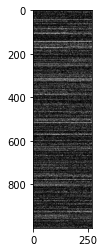

In [ ]:
# We will add missing data as 0s. Therefore, we need to convert the refence allele to -1.
#x[x == 0] = -1

#Add missing data (coded as 0s) to the simulated matrices
# as a percentage according to the empirical data (15% in E. segueriana).
# This step takes a some time.
missD = int(x.shape[1]*x.shape[2]*.15)
for i in range(x.shape[0]):
  for m in range(missD):
    j = random.randint(0, x.shape[1] - 1)
    k = random.randint(0, x.shape[2] - 1)
    x[i][j][k] = 0
del(missD)

#Export an image from the training data, to visualize its appearance
import matplotlib.pyplot as plt
plt.imshow(x[0],cmap='gray', vmin=-1, vmax=1)

In [ ]:
#And visualize the array values.
x[0]

array([[ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       [ 1, -1, -1, ..., -1, -1, -1],
       ...,
       [ 0, -1,  1, ..., -1,  1,  0],
       [-1, -1, -1, ...,  0, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)

In [ ]:
# Separate train (75%) and validate (25%) sets.
xtrain, xtest = x[int(len(y)*.25):], x[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
del(x)
ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)

# Create the CNN network.
model = create_cnn(xtest)

# Compile the CNN.
model.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer='Adam',
	              metrics=['accuracy'])

# We will use early stopping and save the model with the best val_accuracy.
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=0, mode='max', restore_best_weights=True)
### stop training when validation increases error

# Check the architecture.
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 270)]       0         
                                                                 
 conv1d (Conv1D)             (None, 999, 250)          135250    
                                                                 
 average_pooling1d (AverageP  (None, 499, 250)         0         
 ooling1D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 499, 250)         1000      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 498, 125)          62625     
                                                                 
 average_pooling1d_1 (Averag  (None, 249, 125)         0     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-sdnpxq3d
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-sdnpxq3d
  Resolved https://github.com/paulgavrikov/visualkeras to commit d7111d3471173c0b16853a6ce5e4cc645498380a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 25.3 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13450 sha256=6aefa44adf5b5b4e6826283597c2eda3b292abe3669c94dbd17374ae27b5456c
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ze7s8ij/wheels/e6/fe/80/74c54ccb79205ab57079259bc349e1629373e811e1c82ed535
Successfully built visualkeras


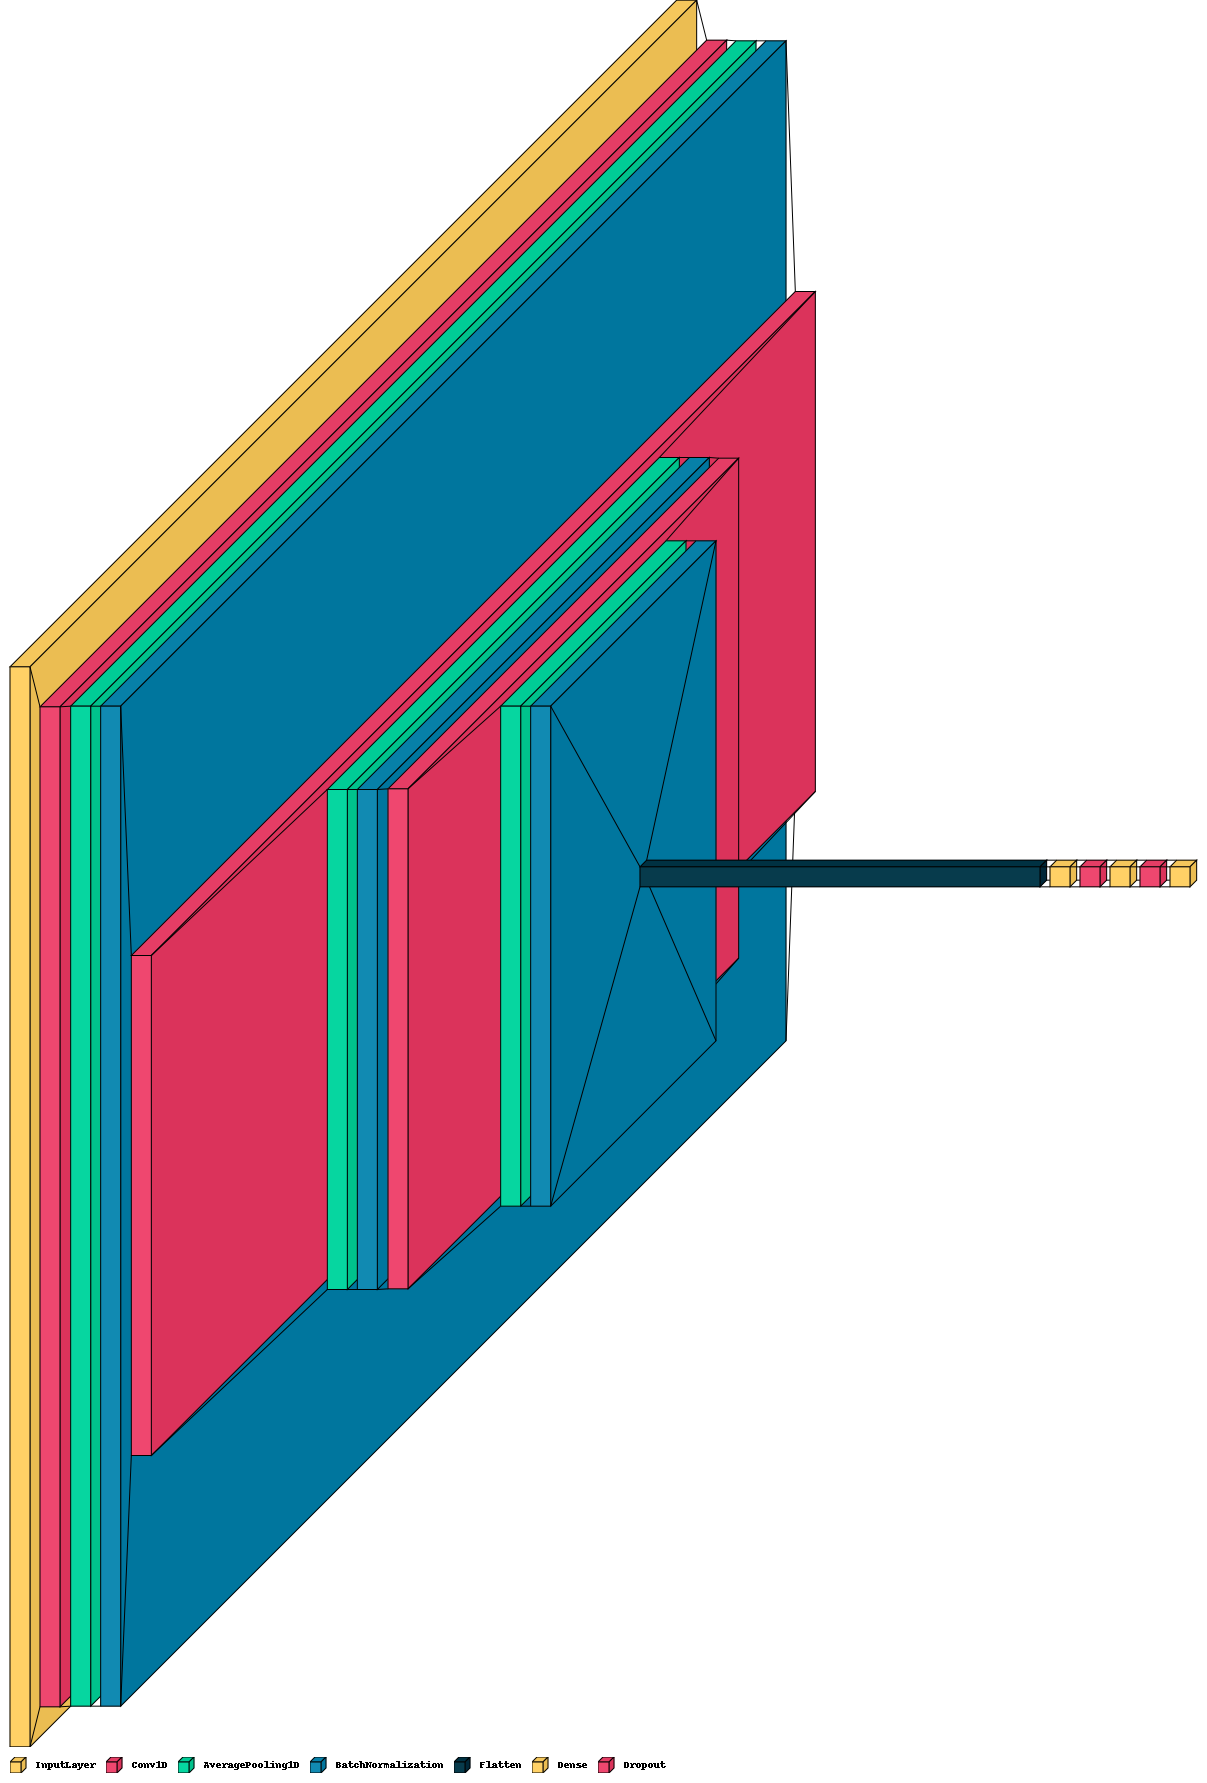

In [ ]:
#We can also have a graphical visualization of the layers
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

In [ ]:
#Run the CNN
history = model.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])

# Save the model.
model.save(filepath='Trained_Esegueriana._MissingData.acc.mod')

Epoch 1/100
12/12 [==============================] - 21s 615ms/step - loss: 1.4777 - accuracy: 0.6040 - val_loss: 26.8378 - val_accuracy: 0.3373
Epoch 2/100
12/12 [==============================] - 2s 130ms/step - loss: 1.0569 - accuracy: 0.7658 - val_loss: 40.1794 - val_accuracy: 0.3373
Epoch 3/100
12/12 [==============================] - 2s 129ms/step - loss: 0.9176 - accuracy: 0.8067 - val_loss: 27.9150 - val_accuracy: 0.3373
Epoch 4/100
12/12 [==============================] - 2s 129ms/step - loss: 0.7844 - accuracy: 0.8716 - val_loss: 8.3343 - val_accuracy: 0.0920
Epoch 5/100
12/12 [==============================] - 2s 128ms/step - loss: 0.7240 - accuracy: 0.9044 - val_loss: 13.6050 - val_accuracy: 0.3453
Epoch 6/100
12/12 [==============================] - 2s 131ms/step - loss: 0.6246 - accuracy: 0.9360 - val_loss: 18.6454 - val_accuracy: 0.3453
Epoch 7/100
12/12 [==============================] - 2s 149ms/step - loss: 0.5894 - accuracy: 0.9538 - val_loss: 18.6212 - val_accuracy:

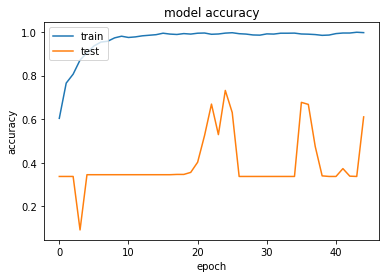

In [ ]:
# Plot training and validation accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Section 3: Perform cross validation predictions with another 100 simulations per model. Those were not seen by the network during training**

300 300
10/10 [==============================] - 0s 17ms/step


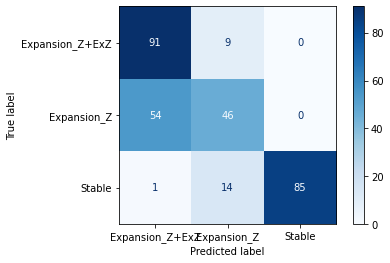

In [ ]:
# Load Numpy test set arrays containing the test set simulations.
u1 = np.load("/content/simulations/testSims/simModel1.npy",mmap_mode='r')
u2 = np.load("/content/simulations/testSims/simModel2.npy",mmap_mode='r')
u3 = np.load("/content/simulations/testSims/simModel3.npy",mmap_mode='r')

# Combine all test set arrays.
xtest=np.concatenate((u1,u2,u3),axis=0)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(xtest):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      xtest[arr][idx][xtest[arr][idx] == 1] = -1
      xtest[arr][idx][xtest[arr][idx] == 0] = 1
    else:
      xtest[arr][idx][xtest[arr][idx] == 0] = -1

# Label each simulated array.
ytest=[0 for i in range(len(u1))]
ytest.extend([1 for i in range(len(u2))])
ytest.extend([2 for i in range(len(u3))])
ytest = np.array(ytest)

#delete temporary files to free memory.
del (u1,u2,u3)

# Print label and simulations length, these should be the same.
print (len(xtest), len(ytest))


#Add missing data (coded as 0s) to the simulated matrices
# as a percentage according to the empirical data (15% in E. segueriana).
missD = int(xtest.shape[1]*xtest.shape[2]*.15)
for i in range(xtest.shape[0]):
  for m in range(missD):
    j = random.randint(0, xtest.shape[1] - 1)
    k = random.randint(0, xtest.shape[2] - 1)
    xtest[i][j][k] = 0
del(missD)

# Predict with the calibrated model and export a confusion matrix.
pred = model.predict(xtest)
pred_cat = [i.argmax() for i in pred]
cm=confusion_matrix(ytest, pred_cat)
scenarios = ['Expansion_Z+ExZ', 'Expansion_Z', 'Stable']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=scenarios)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## **Section 4: Predict the most likely model for the empirical data, using the calibrated CNN.**

In [ ]:
# Load empirical data.
infile=np.loadtxt("/content/drive/MyDrive/Day4/input_Esegueriana.txt")
inp=np.array(infile)

inp.shape

(12125, 270)

In [ ]:
# Create 100 subsets containing 1,000 random SNPs from the full empirical data.
num_samples=100
res = []
for i in range(0,num_samples):
	idx = np.random.choice(inp.shape[0], 1000, replace=False)
	n = inp[idx,:]
	res.append(np.array(n))

Emp = np.array(res)

# Predict model probabilities.
Emp_pred = model.predict(Emp)
print(Emp_pred)

np.savetxt("Emp_ModelPredictions.txt", Emp_pred)

4/4 [==============================] - 1s 150ms/step
[[9.44103718e-01 5.57906218e-02 1.05645282e-04]
 [9.86707568e-01 1.32447574e-02 4.76131900e-05]
 [4.82850105e-01 5.17100990e-01 4.88636797e-05]
 [9.97862518e-01 2.13496876e-03 2.48288939e-06]
 [9.87581611e-01 1.24042006e-02 1.42027739e-05]
 [9.99990225e-01 9.81138328e-06 7.09586168e-09]
 [1.93409100e-01 8.06392789e-01 1.98165624e-04]
 [9.95239019e-01 4.75766696e-03 3.26636655e-06]
 [8.77885520e-01 1.22030981e-01 8.35415194e-05]
 [9.99944448e-01 5.56058912e-05 3.61672754e-08]
 [5.92972815e-01 4.06830430e-01 1.96733279e-04]
 [7.74070919e-01 2.25850657e-01 7.84178919e-05]
 [9.43601310e-01 5.63335195e-02 6.51688242e-05]
 [9.99780715e-01 2.18816625e-04 5.19635819e-07]
 [9.15374875e-01 8.45435113e-02 8.16082102e-05]
 [1.54842958e-01 8.44943821e-01 2.13219697e-04]
 [9.99836326e-01 1.63181976e-04 4.83746931e-07]
 [6.45147026e-01 3.54622066e-01 2.30853737e-04]
 [9.11455810e-01 8.84966105e-02 4.75644811e-05]
 [9.93019521e-01 6.95711700e-03 2.3

## **Section 5: We can also perform parameter estimation.**

In [ ]:
# Define a function to read the parameters file.
def readDemogParams(demogParamPath):
    params = []
    first = True
    with open(demogParamPath) as demogParamFile:
        for line in demogParamFile:
            params.append([float(x) for x in line.strip().split()])
    return params

def create_cnn(xtest):
	inputShape = (xtest.shape[1], xtest.shape[2])
	## image size. images need to have EXACTLY the same size
	inputs = Input(shape=inputShape)
	x = inputs
	## 1D convolution - less computational intensive and also treats snps as independent;
	x = Conv1D(250, kernel_size=2, activation='relu',input_shape=(xtest.shape[1], xtest.shape[2]))(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	x = Conv1D(125, kernel_size=2, activation='relu')(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	x = Conv1D(125, kernel_size=2, activation='relu')(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	### Linearising the image as in the initial step. From this point on the network behaves as a Multi-Layer Perceptron.
	x = Flatten()(x)
	x = Dense(125, activation='relu',kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(x)
	x = Dropout(0.5)(x)
	x = Dense(125, activation='relu',kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(x)
	x = Dropout(0.5)(x)
	# The last layer is a dense according to the number of parameters.
	x = Dense(numParams)(x)# Define the CNN architecture.

	# Construct the CNN.
	model = Model(inputs, x)
	# Return the CNN.
	return model

In [ ]:
from sklearn.preprocessing import StandardScaler

# Load parameters.
demogParams = readDemogParams('/content/simulations/trainingSims/parameters.txt')
y = np.array(demogParams)
numParams=y.shape[1]

#delete temporary files to free memory.
del (demogParams)

scaler= StandardScaler()
y = scaler.fit_transform(y)

#Load simulations for the best model.
u3 = np.load("/content/simulations/trainingSims/simModel2.npy",mmap_mode='r')
x = np.array(u3)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(x):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      x[arr][idx][x[arr][idx] == 1] = -1
      x[arr][idx][x[arr][idx] == 0] = 1
    else:
      x[arr][idx][x[arr][idx] == 0] = -1

# Print label and simulations length, these should be the same.
print (len(x), len(y))

# Shuffle the arrays for training, keeping the labels in the same order.
shf = list(range(len(x)))
shuffle(shf)
y = y[shf]
x = x[shf]

#I will not add missing data here to save time. But it should be done here as well.
#missD = int(x.shape[1]*x.shape[2]*.15)
#for i in range(x.shape[0]):
#  for m in range(missD):
#    j = random.randint(0, x.shape[1] - 1)
#    k = random.randint(0, x.shape[2] - 1)
#    x[i][j][k] = 0
#del(missD)

# Separate train (75%) and validate (25%) sets.
xtrain, xtest = x[int(len(y)*.25):], x[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
del(x)

# Create the CNN network.
cnn = create_cnn(xtest)

# Compile the CNN.
cnn.compile(loss='mean_squared_error',
	              optimizer='Adam')

# Check the architecture.
cnn.summary()

# Run the CNN with early stopping. Save the model with the best val_accuracy.
earlyStopping = EarlyStopping(monitor='val_loss', patience=150, verbose=0, mode='max', restore_best_weights=True)

history = cnn.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])

1000 1000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 270)]       0         
                                                                 
 conv1d_3 (Conv1D)           (None, 999, 250)          135250    
                                                                 
 average_pooling1d_3 (Averag  (None, 499, 250)         0         
 ePooling1D)                                                     
                                                                 
 batch_normalization_3 (Batc  (None, 499, 250)         1000      
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 498, 125)          62625     
                                                                 
 average_pooling1d_4 (Averag  (None, 249, 125)   

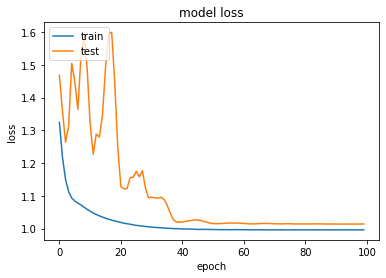

In [ ]:
# Plot training and validation accuracies
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##**Now let's use the test set.**


In [ ]:
# Load the simulations.
x_test = np.load("/content/simulations/testSims/simModel2.npy",mmap_mode='r')
x_test = np.array(x_test)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(xtest):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      xtest[arr][idx][xtest[arr][idx] == 1] = -1
      xtest[arr][idx][xtest[arr][idx] == 0] = 1
    else:
      xtest[arr][idx][xtest[arr][idx] == 0] = -1

#I will not add missing data here to save time. But it should be done here as well.
#missD = int(x_test.shape[1]*x_test.shape[2]*.15)
#for i in range(x_test.shape[0]):
#  for m in range(missD):
#    j = random.randint(0, x_test.shape[1] - 1)
#    k = random.randint(0, x_test.shape[2] - 1)
#    x_test[i][j][k] = 0
#del(missD)

# Predict parameters for each simulation.
pred = cnn.predict(x_test)
#return predictions to their correct scale.
pred = scaler.inverse_transform(pred)
# Save the obtained predictions.
np.savetxt("testSet_ParameterPredictions.txt", pred)

4/4 [==============================] - 0s 10ms/step


In [ ]:
# Load empirical data.
infile=np.loadtxt("/content/drive/MyDrive/Day4/input_Esegueriana.txt")
inp=np.array(infile)

# Create 100 subsets containing 1,000 random SNPs from the full empirical data.
num_samples=100
res = []
for i in range(0,num_samples):
	idx = np.random.choice(inp.shape[0], 1000, replace=False)
	n = inp[idx,:]
	res.append(np.array(n))

# Predict parameters.
Emp_pred = np.array(res)
Emp_pred = cnn.predict(Emp_pred)
#Emp_pred = scaler.inverse_transform(Emp_pred)

np.savetxt("Emp_ParametersPredictions.txt", Emp_pred)

4/4 [==============================] - 0s 17ms/step
